In [1]:
import os
import sys
work_dir = os.path.dirname(os.path.dirname(os.path.abspath('.')))
os.chdir(work_dir)
sys.path.append(os.path.join(work_dir,'src'))
sys.path.append(work_dir)
import numpy as np
import matplotlib.pyplot as plt
from approaches.method import Net
import torch
import yaml
from brain_data import HemiBrain,Celegans19
import os.path as osp
import random

In [2]:
def setup_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) 
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic =True
setup_seed(86)

In [5]:

config='runs/fly-tsne_model/config.yaml'
model_para='runs/fly-tsne_model/checkpoint_best_model.pt'

with open(os.path.join(work_dir,config),'r') as fin:
    task=yaml.load(fin)
task['type_dim']=5555
model=Net(task)


checkpoint=torch.load(os.path.join(work_dir,model_para))
model.load_state_dict(checkpoint.state_dict())
model.cpu()



/data/users/wgj/miniconda3/envs/pygeo/lib/python3.7/site-packages/ipykernel_launcher.py:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  """


Net(
  (Deco): LinkPred(
    (predictor): dot_predictor()
  )
  (node_Enco): NaiveGCN(
    (node_attr_layer): node_attr_encoder(
      (drop1): Dropout(p=0.5, inplace=True)
      (x_embddings): Linear(in_features=5555, out_features=100, bias=False)
    )
    (conv1): GCNConv(100, 512)
    (relu1): ReLU()
    (drop1): Dropout(p=0.5, inplace=True)
    (conv2): GCNConv(512, 256)
  )
  (pair_Enco): NeighEnco(
    (lin): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [6]:
path = osp.join('data', task['Experiment'])
if task['Experiment']=='C.Elegans19':
    dataset = Celegans19(path, transform=None,name=task['var'])
elif task['Experiment']=='HemiBrain':
    dataset=HemiBrain(path,transform=None)

z=model.node_Enco(x=dataset.data.x,edge_index=dataset.data.edge_index)


In [7]:

emb=z.detach().numpy()

In [8]:
from sklearn.manifold import TSNE
X_fit=TSNE(n_components=2,init='pca').fit_transform(emb)


In [9]:
label=dataset.data.y.cpu().numpy().T
print(label.shape)


(21739,)


In [10]:
k=19
label_count={}
for i in label:
    if i in label_count:
        label_count[i]+=1
    else:
        label_count[i]=1
label_sort=sorted(label_count.items(),key=lambda x:x[1],reverse=True)
label_count=label_sort[:500]

topklabel=[i[0] for i in label_count]
res=np.transpose(X_fit)
x,y=res[0],res[1]
colors=['#001219', '#005f73', '#0a9396', '#94d2bd', '#e9d8a6', '#ee9b00', '#ca6702', '#bb3e03', '#ae2012', '#9b2226']+['#9b5de5', '#f15bb5', '#fee440', '#00bbf9', '#00f5d4']+['#5f0f40', '#9a031e', '#fb8b24', '#e36414', '#0f4c5c']

color_dict={k:c for k,c in enumerate(colors)}
ccc=[]
marke=[]
for l in label:
    g=l%k
    if g in color_dict:
        ccc.append(color_dict[g])
    else:
        ccc.append('grey')
    marke.append(r'$%d$'%l)


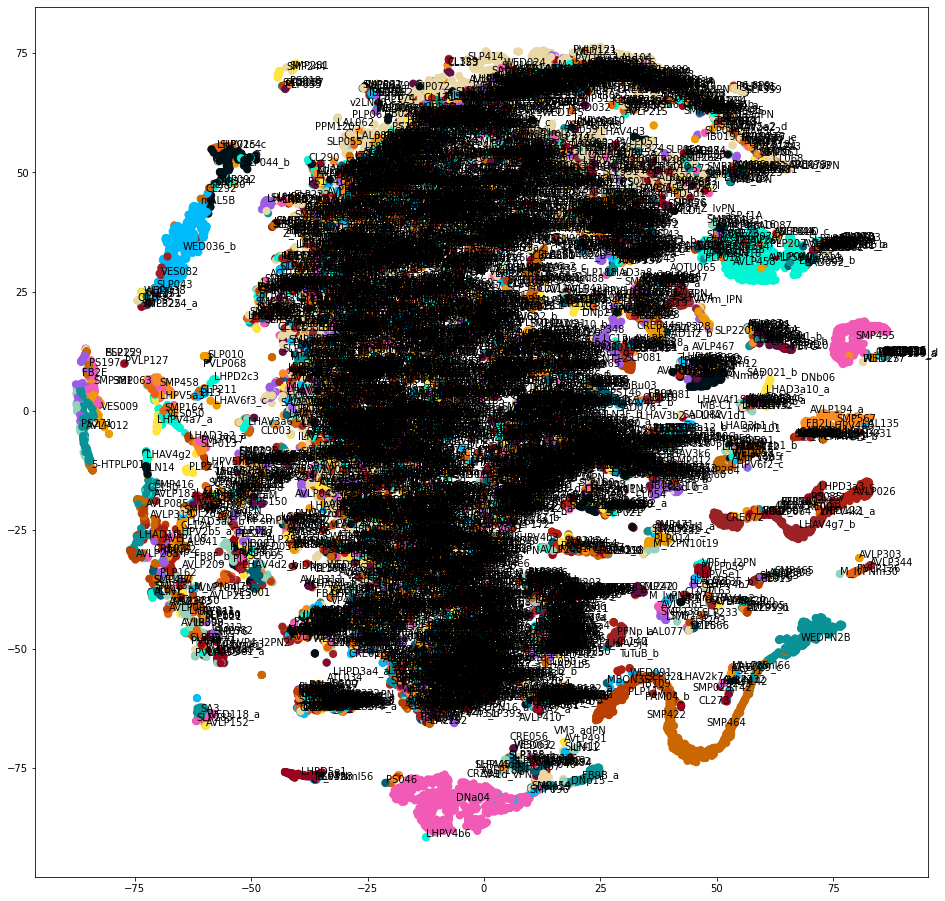

In [11]:
# from approaches.heustic import NxLinkPred
# import networkx as nx
# nxg=NxLinkPred.edge_index2Graph(dataset.data.edge_index.cpu())
#pos=nx.layout.circular_layout(nxg)
pos={}
for k,n in enumerate(X_fit):
    if label[k] in pos:
        pos[label[k]].append(n)
    else:
        pos[label[k]]=[n]

center_pos={}
text_x=[]
text_y=[]
text=[]
for k,v in pos.items():
    v=np.array(v)
    center_pos[k]=np.mean(v,axis=0)

    text_x.append(center_pos[k][0])
    text_y.append(center_pos[k][1])
    text.append(k)

fig,ax=plt.subplots(ncols=1,nrows=1,figsize=(16,16))
y2label={v:k for k,v in dataset.label2ID.items()}
for k,t in enumerate(text):
    ax.annotate(y2label[t],(text_x[k],text_y[k]))
ax.scatter(x,y,c=ccc,s=50)
#fig.savefig(os.path.join(work_dir,'Plot_figure/Main_content','%s-tnse.png'%task['Experiment']))